In [1]:

import numpy as np
import matplotlib.pyplot as plt
import torch as T

device = T.device("cuda:0")  # apply to Tensor or Module



/home/han/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
T.cuda.memory_allocated()

0

In [3]:
# -----------------------------------------------------------

class UciDigitsDataset(T.utils.data.Dataset):
  def __init__(self, src_file, num_rows=None):
    # 0,5,12,13,16, . . (64 values),9(label/digit)
    # 1797 items
    tmp_x = np.loadtxt(src_file, max_rows=num_rows,
      usecols=range(0,64), delimiter=",", skiprows=0,
      dtype=np.float32)
    tmp_x /= 16

    tmp_y = np.loadtxt(src_file, max_rows=num_rows,
      usecols=64, delimiter=",", skiprows=0,
      dtype=np.int64)  # used for graph, not for training

    self.x_data = T.tensor(tmp_x, dtype=T.float32)
    self.y_data = T.tensor(tmp_y, dtype=T.int64) 

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, idx):
    pixels = self.x_data[idx]
    digit = self.y_data[idx] 
    sample = { 'pixels' : pixels, 'digit' : digit }
    return sample



In [4]:
# -----------------------------------------------------------

class Net(T.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.enc1 = T.nn.Linear(64, 16)  # 64-16-2-16-64
    self.enc2 = T.nn.Linear(16, 8)
    self.enc3 = T.nn.Linear(8, 4)
    self.enc4 = T.nn.Linear(4, 2)
    self.dec0 = T.nn.Linear(2, 4)
    self.dec1 = T.nn.Linear(4, 8)
    self.dec2 = T.nn.Linear(8, 16)
    self.dec3 = T.nn.Linear(16, 64)
  
    T.nn.init.xavier_uniform_(self.enc1.weight)
    T.nn.init.zeros_(self.enc1.bias)
    T.nn.init.xavier_uniform_(self.enc2.weight)
    T.nn.init.zeros_(self.enc2.bias)
    T.nn.init.xavier_uniform_(self.dec1.weight)
    T.nn.init.zeros_(self.dec1.bias)
    T.nn.init.xavier_uniform_(self.dec2.weight)
    T.nn.init.zeros_(self.dec2.bias)

  def encode(self, x):
    
    z = T.relu(self.enc1(x))
    z = T.tanh(self.enc2(z))
    z = T.tanh(self.enc3(z))
    z = T.tanh(self.enc4(z))   # act depends on scenario
    return z.to(device)

  def decode(self, x):
    z = T.tanh(self.dec0(x))
    z = T.tanh(self.dec1(z))
    z = T.tanh(self.dec2(z))
    z = self.dec3(z)  # no activation
    return z   

  def forward(self, x):
    
    z = self.encode(x)
    z = self.decode(z)
    return z




Begin UCI digits auto-reduce-viz demo job 

Creating UCI Digits Dataset 

Creating 64-16-2-16-63 autoencoder 

bat_size =  10 
loss = MSELoss()
optimizer = Adam
max_epochs = 200 
lrn_rate = 0.010 

Starting training
epoch =    0   loss = 13.3600
epoch =   10   loss = 8.4880
epoch =   20   loss = 7.7396
epoch =   30   loss = 7.6862
epoch =   40   loss = 7.5551
epoch =   50   loss = 7.4447
epoch =   60   loss = 7.2758
epoch =   70   loss = 7.2024
epoch =   80   loss = 7.1077
epoch =   90   loss = 7.2529
epoch =  100   loss = 7.0600
epoch =  110   loss = 6.9441
epoch =  120   loss = 7.1167
epoch =  130   loss = 7.0270
epoch =  140   loss = 6.9684
epoch =  150   loss = 6.9344
epoch =  160   loss = 7.1317
epoch =  170   loss = 6.9768
epoch =  180   loss = 6.8958
epoch =  190   loss = 6.8145
Done 

Creating graph from encoded data 


/tmp/ipykernel_20781/3598323111.py:88: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rows = np.array(rows, dtype=np.bool)  # list to array


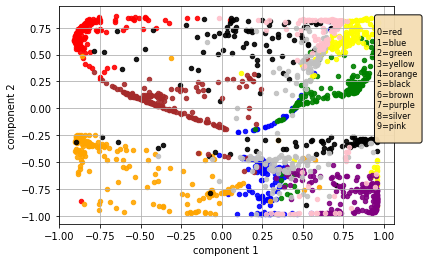


End UCI digits auto-reduce-viz demo


In [5]:
# -----------------------------------------------------------

def main():
  # 0. setup
  print("\nBegin UCI digits auto-reduce-viz demo job ")
  T.manual_seed(1)
  np.random.seed(1)

  # 1. create DataLoader object
  print("\nCreating UCI Digits Dataset ")

  train_file = "digits_uci_test_1797.txt"
  train_ds = UciDigitsDataset(train_file) # all 1797 rows
  

  bat_size = 10
  train_ldr = T.utils.data.DataLoader(train_ds,
    batch_size=bat_size, shuffle=True)

  # 2. create network
  print("\nCreating 64-16-2-16-63 autoencoder ")
  net = Net().to("cuda:0")

  # 3. train model
  max_epochs = 200
  ep_log_interval = 10
  lrn_rate = 0.01

  loss_func = T.nn.MSELoss()
  optimizer = T.optim.Adam(net.parameters(), lr=lrn_rate)

  print("\nbat_size = %3d " % bat_size)
  print("loss = " + str(loss_func))
  print("optimizer = Adam")
  print("max_epochs = %3d " % max_epochs)
  print("lrn_rate = %0.3f " % lrn_rate)

  print("\nStarting training")
  net = net.train()
  for epoch in range(0, max_epochs):
    epoch_loss = 0  # for one full epoch

    for (batch_idx, batch) in enumerate(train_ldr):
      X = batch['pixels'].to(device)  # no targets needed

      optimizer.zero_grad()
      oupt = net(X)
      loss_obj = loss_func(oupt, X)  # note: X not Y
      epoch_loss += loss_obj.item()  # accumulate
      loss_obj.backward()
      optimizer.step()

    if epoch % ep_log_interval == 0:
      print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss))
  print("Done ")

  # 4. plot digits using reduced form
  print("\nCreating graph from encoded data ")
  net = net.eval()
  
  with T.no_grad():
    bow=train_ds[:]['pixels']
    bow=bow.to(device)
    xy = net.encode(bow)  # (1797,2)
  lbls = train_ds[:]['digit']  # (1797,)
  lbls=lbls.to(device)
  xy = xy.to("cpu").detach().numpy()      # tensors to numpy arrays
  lbls = lbls.to("cpu").detach().numpy()
  
  

  fig, ax = plt.subplots()
  colors = ['red', 'blue', 'green', 'yellow', 'orange',
            'black', 'brown', 'purple', 'silver', 'pink']
  digits = [' 0 ', ' 1 ', ' 2 ', ' 3 ', ' 4 ',
            ' 5 ', ' 6 ', ' 7 ', ' 8 ', ' 9 ']

  # process by each color/class
  for i in range(len(colors)):  # 0 to 9 each color
    color = colors[i]
    rows = []                   # select rows for curr color
    for j in range(len(xy)):    # 0 to 1796
      if lbls[j] == i:
        rows.append(True)       # to extract rows, must use bool
      else:
        rows.append(False)

    rows = np.array(rows, dtype=np.bool)  # list to array
    selected = xy[rows,:]                 # like (178,2)

    x = selected[:,0]  # like (178,)
    y = selected[:,1]
    scatter  = ax.scatter(x, y, c=color, s=20, alpha=0.9)
    # and continue on to next color/class

  txt = "\n" + "0=red \n" + "1=blue \n" + "2=green \n" + \
    "3=yellow \n" + "4=orange \n" + "5=black \n" + \
    "6=brown \n" + "7=purple \n" + "8=silver \n" + "9=pink \n"

  props = dict(boxstyle='round', facecolor='wheat', alpha=0.95)
  ax.text(0.95, 0.95, txt, transform=ax.transAxes, fontsize=8,
    verticalalignment='top', bbox=props)
  ax.grid(True)
  plt.xlabel('component 1')
  plt.ylabel('component 2')
  plt.show()

  print("\nEnd UCI digits auto-reduce-viz demo")

if __name__ == "__main__":
  main()

NameError: name 'lbls' is not defined

: 

In [ ]:
train_file = "digits_uci_test_1797.txt"
train_ds = UciDigitsDataset(train_file)

In [ ]:
len(train_ds)

In [ ]:
# -----------------------------------------------------------


# 0. setup
print("\nBegin UCI digits auto-reduce-viz demo job ")
T.manual_seed(1)
np.random.seed(1)

# 1. create DataLoader object
print("\nCreating UCI Digits Dataset ")

train_file = "digits_uci_test_1797.txt"
train_ds = UciDigitsDataset(train_file) # all 1797 rows


bat_size = 10
train_ldr = T.utils.data.DataLoader(train_ds,
batch_size=bat_size, shuffle=True)

# 2. create network
print("\nCreating 64-16-2-16-63 autoencoder ")
net = Net().to("cuda:0")

# 3. train model
max_epochs = 200
ep_log_interval = 10
lrn_rate = 0.01

loss_func = T.nn.MSELoss()
optimizer = T.optim.Adam(net.parameters(), lr=lrn_rate)

print("\nbat_size = %3d " % bat_size)
print("loss = " + str(loss_func))
print("optimizer = Adam")
print("max_epochs = %3d " % max_epochs)
print("lrn_rate = %0.3f " % lrn_rate)

print("\nStarting training")
net = net.train()
for epoch in range(0, max_epochs):
    epoch_loss = 0  # for one full epoch

    for (batch_idx, batch) in enumerate(train_ldr):
        X = batch['pixels'].to(device)  # no targets needed

        optimizer.zero_grad()
        oupt = net(X)
        loss_obj = loss_func(oupt, X)  # note: X not Y
        epoch_loss += loss_obj.item()  # accumulate
        loss_obj.backward()
        optimizer.step()

    if epoch % ep_log_interval == 0:
        print("epoch = %4d   loss = %0.4f" % (epoch, epoch_loss))
print("Done ")

# 4. plot digits using reduced form
print("\nCreating graph from encoded data ")
net = net.eval()

with T.no_grad():
    bow=train_ds[:]['pixels']
    bow=bow.to(device)
    xy = net.encode(bow)  # (1797,2)
    lbls = train_ds[:]['digit']  # (1797,)
    lbls=lbls.to(device)
    xy = xy.to("cpu").detach().numpy()      # tensors to numpy arrays
    lbls = lbls.to("cpu").detach().numpy()



fig, ax = plt.subplots()
colors = ['red', 'blue', 'green', 'yellow', 'orange',
        'black', 'brown', 'purple', 'silver', 'pink']
digits = [' 0 ', ' 1 ', ' 2 ', ' 3 ', ' 4 ',
        ' 5 ', ' 6 ', ' 7 ', ' 8 ', ' 9 ']

# process by each color/class
for i in range(len(colors)):  # 0 to 9 each color
    color = colors[i]
rows = []                   # select rows for curr color
for j in range(len(xy)):    # 0 to 1796
    if lbls[j] == i:
        rows.append(True)       # to extract rows, must use bool
    else:
        rows.append(False)

rows = np.array(rows, dtype=np.bool)  # list to array
selected = xy[rows,:]                 # like (178,2)

x = selected[:,0]  # like (178,)
y = selected[:,1]
scatter  = ax.scatter(x, y, c=color, s=20, alpha=0.9)
# and continue on to next color/class

txt = "\n" + "0=red \n" + "1=blue \n" + "2=green \n" + \
"3=yellow \n" + "4=orange \n" + "5=black \n" + \
"6=brown \n" + "7=purple \n" + "8=silver \n" + "9=pink \n"

props = dict(boxstyle='round', facecolor='wheat', alpha=0.95)
ax.text(0.95, 0.95, txt, transform=ax.transAxes, fontsize=8,
verticalalignment='top', bbox=props)
ax.grid(True)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()

print("\nEnd UCI digits auto-reduce-viz demo")


In [ ]:
lbls.shape

In [ ]:
lbls

In [ ]:
xy

In [ ]:
plt.scatter(xy[:,0],xy[:,1])

In [ ]:
xy[:,0].shape

In [ ]:
xy[:,0].shape